# Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
import pandas as pd
import numpy as np
import re
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import TransformerConv
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn

# Data Parsing

### Load dataset

In [80]:
df = pd.read_csv('./data/dataSetB.csv')
df = df[[col for col in df if "NameRxn" in col]]

### Smiles to Reactions

In [81]:
def parse_rxn_smile(rxn_smile,reactant_set):
    before_rxn_smile, products_smile = rxn_smile.split('>>')

    reactant_indices = [int(x) for x in re.findall(r'\d+', reactant_set)]

    potential_reactants = before_rxn_smile.split('.')
    reactants = [potential_reactants[idx] for idx in reactant_indices]

    products = products_smile.split('.')

    return reactants,products

In [82]:
rxn_list = []
for idx, row in df.iterrows():
    rxn_smile = row['rxnSmiles_Mapping_NameRxn']
    reactant_set = row['reactantSet_NameRxn']

    reactants, products = parse_rxn_smile(rxn_smile,reactant_set)

    reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
    product_mols = [Chem.MolFromSmiles(product) for product in products]

    rxn_list.append((reactant_mols,product_mols))


### Reaction cleanup

In [83]:
# # problems_w = 0
# # problems_e = 0
# # i = 0
cleaned_rxn_list = []
for idx, rxn in enumerate(rxn_list):
    rd_rxn = rdChemReactions.ChemicalReaction()
    for rctnt in rxn[0]:
        rd_rxn.AddReactantTemplate(rctnt)
    for prdct in rxn[1]:
        rd_rxn.AddProductTemplate(prdct)

    warnings, errors = rd_rxn.Validate()
    if(not warnings and not errors and not len(rxn[1])>1):
        cleaned_rxn_list.append(rd_rxn)
#     # problems_w+=warnings
#     # problems_e+=errors
# # print(problems_w,problems_e)

[19:13:38] product atom-mapping number 1 found multiple times.
[19:13:38] product atom-mapping number 2 found multiple times.
[19:13:38] product atom-mapping number 3 found multiple times.
[19:13:38] product atom-mapping number 4 found multiple times.
[19:13:38] product atom-mapping number 5 found multiple times.
[19:13:38] product atom-mapping number 6 found multiple times.
[19:13:38] product atom-mapping number 7 found multiple times.
[19:13:38] product atom-mapping number 25 found multiple times.
[19:13:38] product atom-mapping number 26 found multiple times.
[19:13:38] product atom-mapping number 27 found multiple times.
[19:13:38] product atom-mapping number 28 found multiple times.
[19:13:38] product atom-mapping number 29 found multiple times.
[19:13:38] product atom-mapping number 30 found multiple times.
[19:13:38] product atom-mapping number 31 found multiple times.
[19:13:38] product atom-mapping number 32 found multiple times.
[19:13:38] product atom-mapping number 33 found

# Feature extraction

In [84]:
symbol_list = [
        'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
        'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
    ]

hyb_list = [
    Chem.rdchem.HybridizationType.SP, 
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
    ]

bt_list = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC
]

sym_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
hyb_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
bt_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)

sym_encoder.fit(np.array(symbol_list).reshape(-1,1))
hyb_encoder.fit(np.array(hyb_list).reshape(-1,1))
bt_encoder.fit(np.array(bt_list).reshape(-1,1))

def one_hot_encode(symbol,encoder):
    try: 
        return torch.tensor(encoder.transform(np.array([[symbol]])).reshape(-1), dtype=torch.float)
    except:
        return torch.tensor(encoder.transform(np.array([['unk']])).reshape(-1), dtype=torch.float)


In [85]:
def get_atom_features(atom):
    sym_one_hot = one_hot_encode(atom.GetSymbol(),sym_encoder)
    formal_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
    degree = torch.tensor([atom.GetDegree()], dtype=torch.float)
    total_hydrogens = torch.tensor([atom.GetTotalNumHs()], dtype=torch.float)
    valence = torch.tensor([atom.GetTotalValence()], dtype=torch.float)
    is_aromatic = torch.tensor([atom.GetIsAromatic()], dtype=torch.float)
    is_in_ring = torch.tensor([atom.IsInRing()], dtype=torch.float)
    hyb_one_hot = one_hot_encode(atom.GetHybridization(),hyb_encoder)
    
    features = torch.cat([sym_one_hot, formal_charge, degree, total_hydrogens, valence, is_aromatic, is_in_ring, hyb_one_hot])

    return features


def get_bond_features(bond):
    # bond type, conjugation, ring membership,  stereo config
    bt_one_hot = one_hot_encode(bond.GetBondType(),bt_encoder)
    is_conjugated = torch.tensor([bond.GetIsConjugated()],dtype=torch.float)
    is_in_ring = torch.tensor([bond.IsInRing()],dtype=torch.float)

    
    features = torch.cat([bt_one_hot,is_conjugated,is_in_ring])

    return(features)


# Input Preparation

In [86]:
def get_broken_bonds(reactants,product):
    reactant_bonds = set()
    product_bonds = set()
    for rc in reactants:
        for bond in rc.GetBonds():
            atom1_map = bond.GetBeginAtom().GetAtomMapNum()
            atom2_map = bond.GetEndAtom().GetAtomMapNum()

            if atom1_map and atom2_map:
                reactant_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    for bond in product.GetBonds():
        atom1_map = bond.GetBeginAtom().GetAtomMapNum()
        atom2_map = bond.GetEndAtom().GetAtomMapNum()
        
        if atom1_map and atom2_map:
            product_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    broken_bonds = reactant_bonds - product_bonds
    formed_bonds = product_bonds - reactant_bonds

    return formed_bonds

In [87]:

def rxn_to_graph(rxn):
    reactants = rxn.GetReactants()
    product = rxn.GetProducts()[0]
    
    map_to_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in product.GetAtoms()}

    center_bonds_map_nums = get_broken_bonds(reactants, product)
    atom_features_list = [get_atom_features(atom) for atom in product.GetAtoms()]
    x = torch.stack(atom_features_list, dim=0)

    # Get edge and edge_attr
    source_nodes, target_nodes = [], []
    bond_features_list = []
    edge_labels = []

    center_bonds_rdkit_indices = set()
    if center_bonds_map_nums:
        for map1, map2 in center_bonds_map_nums:
            # Use the map to get the correct 0-based index
            idx1 = map_to_idx.get(map1)
            idx2 = map_to_idx.get(map2)
            if idx1 is not None and idx2 is not None:
                 center_bonds_rdkit_indices.add(tuple(sorted((idx1, idx2))))

    product_bonds = product.GetBonds()
    if(len(product_bonds) > 0):
        for bond in product_bonds:
            start_idx, end_idx = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_feat = get_bond_features(bond)
            
            # Add edges in both directions
            source_nodes.extend([start_idx, end_idx])
            target_nodes.extend([end_idx, start_idx])
            
            # Add bond features for both directions
            bond_features_list.extend([bond_feat, bond_feat])

            canonical_bond = tuple(sorted((start_idx, end_idx)))
            if canonical_bond in center_bonds_rdkit_indices:
                label = 1.0
            else:
                label = 0.0

            edge_labels.extend([label,label])

        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        edge_attr = torch.stack(bond_features_list, dim=0)
    else:
        return None

    y = torch.tensor(edge_labels, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    

In [ ]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

# dataset = [rxn_to_graph(rxn) for rxn in tqdm(cleaned_rxn_list)]
dataset = torch.load('rxn_graphs.pt')

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size : train_size + val_size]
test_dataset = dataset[train_size + val_size :]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No need to shuffle for eval
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using cuda.


# Model Definition

In [112]:
HIDDEN = 128
HEADS = 8

In [ ]:
from torch_geometric.nn import global_mean_pool
class GraphTransformer(nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_channels, out_channels, heads=HEADS):
        super().__init__()
        out_channels_per_head = hidden_channels // heads
        
        self.conv1 = TransformerConv(in_channels, out_channels_per_head, heads=heads, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, out_channels, heads=1, concat=False, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x, edge_index, edge_attr=edge_attr)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.4, training=self.training)
        h = self.conv2(h, edge_index, edge_attr=edge_attr)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, h, edge_index):
        source_embeds = h[edge_index[0]]
        target_embeds = h[edge_index[1]]
        concat_embeds = torch.cat([source_embeds, target_embeds], dim=1)
        return self.mlp(concat_embeds)

class GNN_LinkPredictor(nn.Module):
    def __init__(self, node_in, edge_in, gnn_hidden, mlp_hidden):
        super().__init__()
        self.gnn = GraphTransformer(
            in_channels=node_in,
            edge_dim=edge_in,
            hidden_channels=gnn_hidden,
            out_channels=gnn_hidden
        )
        self.predictor = LinkPredictor(gnn_hidden*2, mlp_hidden)

    def forward(self, x, edge_index, edge_attr, edge_label_index, batch):
        node_embeddings = self.gnn(x, edge_index, edge_attr)
        graph_embedding = global_mean_pool(node_embeddings, batch)
        graph_embedding_expanded = graph_embedding[batch]
        node_embeddings_with_context = torch.cat(
            [node_embeddings, graph_embedding_expanded], dim=1
        )
        return self.predictor(node_embeddings_with_context, edge_label_index)

In [ ]:
from sklearn.metrics import roc_auc_score
# Model instantiation
node_feature_dim = dataset[0].num_node_features
edge_feature_dim = dataset[0].num_edge_features


model = GNN_LinkPredictor(node_feature_dim, edge_feature_dim, gnn_hidden=HIDDEN, mlp_hidden=32).to(device)
# model = torch.load('model2.pt', weights_only=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

num_positives = 0
num_negatives = 0

for data in train_dataset:
    num_positives += (data.y == 1).sum()
    num_negatives += (data.y == 0).sum()

# Handle case with zero positives to avoid division by zero
if num_positives > 0:
    pos_weight_value = num_negatives / num_positives
else:
    pos_weight_value = 1.0

# Create the final weight tensor and move it to the correct device
pos_weight = torch.tensor([pos_weight_value], device=device)

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


def train(loader):
    model.train()
    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)

        optimizer.zero_grad()

        out = model(
            batch.x, 
            batch.edge_index,
            batch.edge_attr, 
            batch.edge_index,
            batch.batch
        )
        
        loss = criterion(out.view(-1), batch.y)
        # ------------------------

        loss.backward()
        optimizer.step()

@torch.no_grad()
def test(loader):

    
    model.eval()
    all_preds, all_labels = [], []

    for batch in loader:
        batch = batch.to(device)
        
        # Get predictions for ALL bonds in the batch
        preds = model(
            batch.x, 
            batch.edge_index, 
            batch.edge_attr, 
            batch.edge_index,
            batch.batch
        )
        
        # Use the pre-computed labels from batch.y
        labels = batch.y
        
        all_preds.append(preds.sigmoid().cpu())
        all_labels.append(labels.cpu())

    if not all_labels:
        return 0.0, 0.0  # Return 0 for both AUC and F1

    all_labels_tensor = torch.cat(all_labels)
    all_preds_tensor = torch.cat(all_preds)
    
    # Calculate Metrics
    auc = roc_auc_score(all_labels_tensor, all_preds_tensor)
    # f1 = f1_score(all_labels_tensor, (all_preds_tensor > threshold).int())
    
    return auc, all_labels_tensor, all_preds_tensor




In [103]:
for epoch in range(1, 21):
   train(train_loader)
   val_auc,_, _ = test(val_loader)
   print(f'Epoch: {epoch:02d}, Val AUC: {val_auc:.4f}')

# torch.save(model,'model2.pt')

Training: 100%|██████████| 1206/1206 [00:12<00:00, 100.09it/s]


Epoch: 01, Val AUC: 0.8379


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.76it/s]


Epoch: 02, Val AUC: 0.8944


Training: 100%|██████████| 1206/1206 [00:11<00:00, 100.79it/s]


Epoch: 03, Val AUC: 0.9143


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.31it/s]


Epoch: 04, Val AUC: 0.9233


Training: 100%|██████████| 1206/1206 [00:11<00:00, 107.30it/s]


Epoch: 05, Val AUC: 0.9288


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.11it/s]


Epoch: 06, Val AUC: 0.9323


Training: 100%|██████████| 1206/1206 [00:10<00:00, 112.37it/s]


Epoch: 07, Val AUC: 0.9353


Training: 100%|██████████| 1206/1206 [00:11<00:00, 108.50it/s]


Epoch: 08, Val AUC: 0.9376


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.77it/s] 


Epoch: 09, Val AUC: 0.9395


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.85it/s]


Epoch: 10, Val AUC: 0.9411


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.29it/s]


Epoch: 11, Val AUC: 0.9425


Training: 100%|██████████| 1206/1206 [00:12<00:00, 100.11it/s]


Epoch: 12, Val AUC: 0.9437


Training: 100%|██████████| 1206/1206 [00:12<00:00, 98.52it/s] 


Epoch: 13, Val AUC: 0.9449


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.30it/s]


Epoch: 14, Val AUC: 0.9459


Training: 100%|██████████| 1206/1206 [00:11<00:00, 101.29it/s]


Epoch: 15, Val AUC: 0.9469


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.20it/s]


Epoch: 16, Val AUC: 0.9479


Training: 100%|██████████| 1206/1206 [00:11<00:00, 103.53it/s]


Epoch: 17, Val AUC: 0.9486


Training: 100%|██████████| 1206/1206 [00:11<00:00, 100.70it/s]


Epoch: 18, Val AUC: 0.9494


Training: 100%|██████████| 1206/1206 [00:12<00:00, 100.40it/s]


Epoch: 19, Val AUC: 0.9501


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.56it/s]


Epoch: 20, Val AUC: 0.9507


Evaluating final model and generating ROC curve...
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    262152
         1.0       0.24      0.79      0.37      7210

    accuracy                           0.93    269362
   macro avg       0.62      0.86      0.67    269362
weighted avg       0.97      0.93      0.95    269362



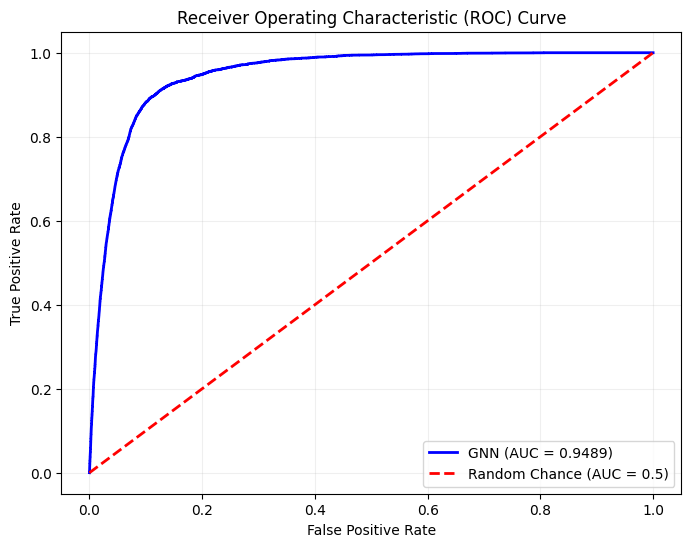

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report

# --- After your training loop is finished ---
print("Evaluating final model and generating ROC curve...")

# 1. Get the final AUC, labels, and predictions from your test set
final_auc, true_labels, predictions = test(test_loader) # or use val_loader

binary_preds = (predictions > 0.80).int()

print(classification_report(true_labels,binary_preds))

if true_labels is not None:
    # 2. Calculate the points for the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)

    # 3. Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'GNN (AUC = {final_auc:.4f})')
    
    # Plot the random chance line
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Chance (AUC = 0.5)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl


class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, e_in_dim, e_out_dim):
        super(GATLayer, self).__init__()
        self.embed_node = nn.Linear(in_dim, out_dim, bias=False)
        self.attn_fc = nn.Linear(2 * out_dim + e_in_dim, 1, bias=False)
        self.to_node_fc = nn.Linear(out_dim + e_in_dim, out_dim, bias=False)
        self.edge_linear = nn.Linear(2 * out_dim + e_in_dim,
                                     e_out_dim,
                                     bias=False)

    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['h'], edges.dst['h'], edges.data['w']],
                       dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a, negative_slope=0.1)}

    def message_func(self, edges):
        return {
            'h': edges.src['h'],
            'e': edges.data['e'],
            'w': edges.data['w']
        }

    def reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        t = torch.cat([nodes.mailbox['h'], nodes.mailbox['w']], dim=-1)
        t = self.to_node_fc(t)
        h = torch.sum(alpha * t, dim=1)
        return {'h': h}

    def edge_calc(self, edges):
        z2 = torch.cat([edges.src['h'], edges.dst['h'], edges.data['w']],
                       dim=1)
        w = self.edge_linear(z2)
        return {'w': w}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = self.embed_node(h)
            g.apply_edges(self.edge_attention)
            g.update_all(self.message_func, self.reduce_func)
            g.apply_edges(self.edge_calc)
            # h_readout = dgl.mean_nodes(g, 'h')
            # gh = dgl.broadcast_nodes(g, h_readout)
            # return torch.cat((g.ndata['h'], gh), dim=1), g.edata['w']
            return g.ndata['h'], g.edata['w']


class MultiHeadGATLayer(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 e_in_dim,
                 e_out_dim,
                 num_heads,
                 use_gpu=True):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        self.use_gpu = use_gpu
        for i in range(num_heads):
            self.heads.append(GATLayer(in_dim, out_dim, e_in_dim, e_out_dim))

    def forward(self, g, h, merge):
        if self.use_gpu:
            g.edata['w'] = g.edata['w'].cuda()
        outs = list(map(lambda x: x(g, h), self.heads))
        outs = list(map(list, zip(*outs)))
        head_outs = outs[0]
        edge_outs = outs[1]
        if merge == 'flatten':
            head_outs = torch.cat(head_outs, dim=1)
            edge_outs = torch.cat(edge_outs, dim=1)
        elif merge == 'mean':
            head_outs = torch.mean(torch.stack(head_outs), dim=0)
            edge_outs = torch.mean(torch.stack(edge_outs), dim=0)
        g.edata['w'] = edge_outs
        return head_outs, edge_outs


class GATNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, heads, use_gpu=True):
        super(GATNet, self).__init__()
        self.num_layers = num_layers
        self.gat = nn.ModuleList()

        self.gat.append(
            MultiHeadGATLayer(in_dim, hidden_dim, 12, 128, heads, use_gpu))
        for l in range(1, num_layers):
            self.gat.append(
                MultiHeadGATLayer(
                    hidden_dim * heads,
                    hidden_dim,
                    128 * heads,
                    128,
                    heads,
                    use_gpu,
                ))

        self.linear_e = nn.Sequential(
            nn.Linear(128 * 2, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

        self.linear_h = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(32, 3),
        )

    def forward(self, g, h):
        for l in range(self.num_layers - 1):
            h, _ = self.gat[l](g, h, merge='flatten')
            h = F.elu(h)
        h, e = self.gat[-1](g, h, merge='mean')

        # Graph level prediction
        g.ndata['h'] = h
        h_readout = dgl.mean_nodes(g, 'h')
        h_pred = self.linear_h(h_readout)

        # Edge prediction
        eh = dgl.broadcast_edges(g, h_readout)
        e_fused = torch.cat((eh, e), dim=1)
        e_pred = self.linear_e(e_fused)

        return h_pred, e_pred
